In [1]:
import json
from PIL import Image
from datetime import datetime
from pathlib import Path

def parse_polygon(polygon_str):
    """Convert polygon string to list of coordinates."""
    coords = []
    points = polygon_str.split(';')
    for point in points:
        x, y = map(int, point.split(','))
        coords.extend([x, y])
    return coords

def parse_bbox(bbox_str):
    """Convert bbox string to [x, y, width, height] format."""
    parts = list(map(int, bbox_str.split(',')))
    x_min, y_min, x_max, y_max = parts
    width = x_max - x_min
    height = y_max - y_min
    return [x_min, y_min, width, height]

def calculate_area(polygon_coords):
    """Calculate polygon area using shoelace formula."""
    n = len(polygon_coords) // 2
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += polygon_coords[2*i] * polygon_coords[2*j + 1]
        area -= polygon_coords[2*j] * polygon_coords[2*i + 1]
    return abs(area) / 2.0

def generate_coco_annotation(tiff_path, geometry_path, class_mapping_path, output_path):
    """Generate COCO format annotation from TIFF and data files."""
    
    # Load the TIFF image to get dimensions
    img = Image.open(tiff_path)
    img_width, img_height = img.size
    img_filename = tiff_path.name
    
    # Initialize COCO structure
    coco_output = {
        "info": {
            "description": "Petiole Dataset",
            "version": "1.0",
            "year": 2026,
            "contributor": "ALS",
            "date_created": datetime.now().strftime("%Y/%m/%d")
        },
        "licenses": [
            {
                "id": 1,
                "name": "Unknown",
                "url": ""
            }
        ],
        "categories": [
            {"id": 1, "name": "Cortex", "supercategory": "object"},
            {"id": 2, "name": "Phloem Fibers", "supercategory": "object"},
            {"id": 3, "name": "Phloem", "supercategory": "object"},
            {"id": 4, "name": "Xylem vessels", "supercategory": "object"},
            {"id": 5, "name": "Air-based Pith cells", "supercategory": "object"},
            {"id": 6, "name": "Water-based Pith cells", "supercategory": "object"}
        ],
        "images": [],
        "annotations": []
    }
    
    # Add image information
    image_info = {
        "id": 1,
        "file_name": img_filename,
        "width": img_width,
        "height": img_height,
        "license": 1,
        "date_captured": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    coco_output["images"].append(image_info)
    
    # Load class mappings
    class_map = {}
    with open(class_mapping_path, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                object_id = int(parts[0])
                class_id = int(parts[1])
                class_map[object_id] = class_id
    
    # Load geometry and create annotations
    with open(geometry_path, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                object_id = int(parts[0])
                polygon_str = parts[1]
                bbox_str = parts[2]
                
                # Get class ID for this object
                category_id = class_map.get(object_id, 6)  # Default to 6 if not found
                
                # Parse polygon and bbox
                segmentation = parse_polygon(polygon_str)
                bbox = parse_bbox(bbox_str)
                area = calculate_area(segmentation)
                
                # Create annotation
                annotation = {
                    "id": object_id,
                    "image_id": 1,
                    "category_id": category_id,
                    "segmentation": [segmentation],
                    "area": area,
                    "bbox": bbox,
                    "iscrowd": 0
                }
                coco_output["annotations"].append(annotation)
    
    # Save to JSON file
    with open(output_path, 'w') as f:
        json.dump(coco_output, f, indent=4)
    
    print(f"✓ COCO annotation created: {output_path.name}")
    print(f"  Total objects: {len(coco_output['annotations'])}")
    
    return len(coco_output['annotations'])

def batch_generate_coco(images_dir, meta_dir, coco_dir):
    """
    Generate COCO annotations for all images with cleaned metadata.
    
    Args:
        images_dir: directory containing image files (.tiff or .tif)
        meta_dir: directory containing cleaned txt metadata files
        coco_dir: directory to save COCO JSON files
    """
    # Create output directory if it doesn't exist
    coco_dir = Path(coco_dir)
    coco_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    images_dir = Path(images_dir)
    image_files = list(images_dir.glob("*.tiff")) + list(images_dir.glob("*.tif"))
    
    print(f"Found {len(image_files)} image files")
    
    processed_count = 0
    skipped_count = 0
    total_objects = 0
    
    for image_path in sorted(image_files):
        base_name = image_path.stem
        
        print(f"\n{'='*80}")
        print(f"Processing: {base_name}")
        print(f"{'='*80}")
        
        # Find corresponding cleaned txt files
        meta_dir_path = Path(meta_dir)
        geometry_path = meta_dir_path / f"{base_name}_object_geometry_cleaned.txt"
        class_mapping_path = meta_dir_path / f"{base_name}_object_class_mapping_cleaned.txt"
        
        # Check if all files exist
        if not geometry_path.exists():
            print(f"Skipping: geometry file not found")
            skipped_count += 1
            continue
        
        if not class_mapping_path.exists():
            print(f"Skipping: class mapping file not found")
            skipped_count += 1
            continue
        
        # Generate COCO annotation
        output_path = coco_dir / f"{base_name}.json"
        
        try:
            num_objects = generate_coco_annotation(
                image_path, 
                geometry_path, 
                class_mapping_path, 
                output_path
            )
            total_objects += num_objects
            processed_count += 1
        except Exception as e:
            print(f"Error processing {base_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            skipped_count += 1
    
    print(f"\n{'='*80}")
    print("Batch COCO generation complete!")
    print(f"Processed: {processed_count} files")
    print(f"Skipped: {skipped_count} files")
    print(f"Total objects annotated: {total_objects}")
    print(f"Output directory: {coco_dir}")
    print(f"{'='*80}")

# Usage
if __name__ == "__main__":
    images_dir = "./data/images"
    meta_dir = "./data/meta"
    coco_dir = "./data/coco"
    
    batch_generate_coco(images_dir, meta_dir, coco_dir)

Found 20 image files

Processing: 20211222_094342_petiole_test_00100
✓ COCO annotation created: 20211222_094342_petiole_test_00100.json
  Total objects: 1618

Processing: 20211222_094342_petiole_test_00200
✓ COCO annotation created: 20211222_094342_petiole_test_00200.json
  Total objects: 1765

Processing: 20211222_094342_petiole_test_00300
✓ COCO annotation created: 20211222_094342_petiole_test_00300.json
  Total objects: 1753

Processing: 20211222_094342_petiole_test_00400
✓ COCO annotation created: 20211222_094342_petiole_test_00400.json
  Total objects: 1844

Processing: 20211222_094342_petiole_test_00500
✓ COCO annotation created: 20211222_094342_petiole_test_00500.json
  Total objects: 1789

Processing: 20211222_104840_petiole_test2_00100
✓ COCO annotation created: 20211222_104840_petiole_test2_00100.json
  Total objects: 1942

Processing: 20211222_104840_petiole_test2_00200
✓ COCO annotation created: 20211222_104840_petiole_test2_00200.json
  Total objects: 2110

Processing: 202


Randomly selected: 20211222_094342_petiole_test_00100.tiff
COCO annotation file: 20211222_094342_petiole_test_00100.json

Total number of objects: 1618

Objects per class:
  Cortex: 1334
  Phloem Fibers: 28
  Phloem: 1
  Xylem vessels: 131
  Air-based Pith cells: 17
  Water-based Pith cells: 107

Visualization saved to: data/verification/20211222_094342_petiole_test_00100_coco_visualization.png


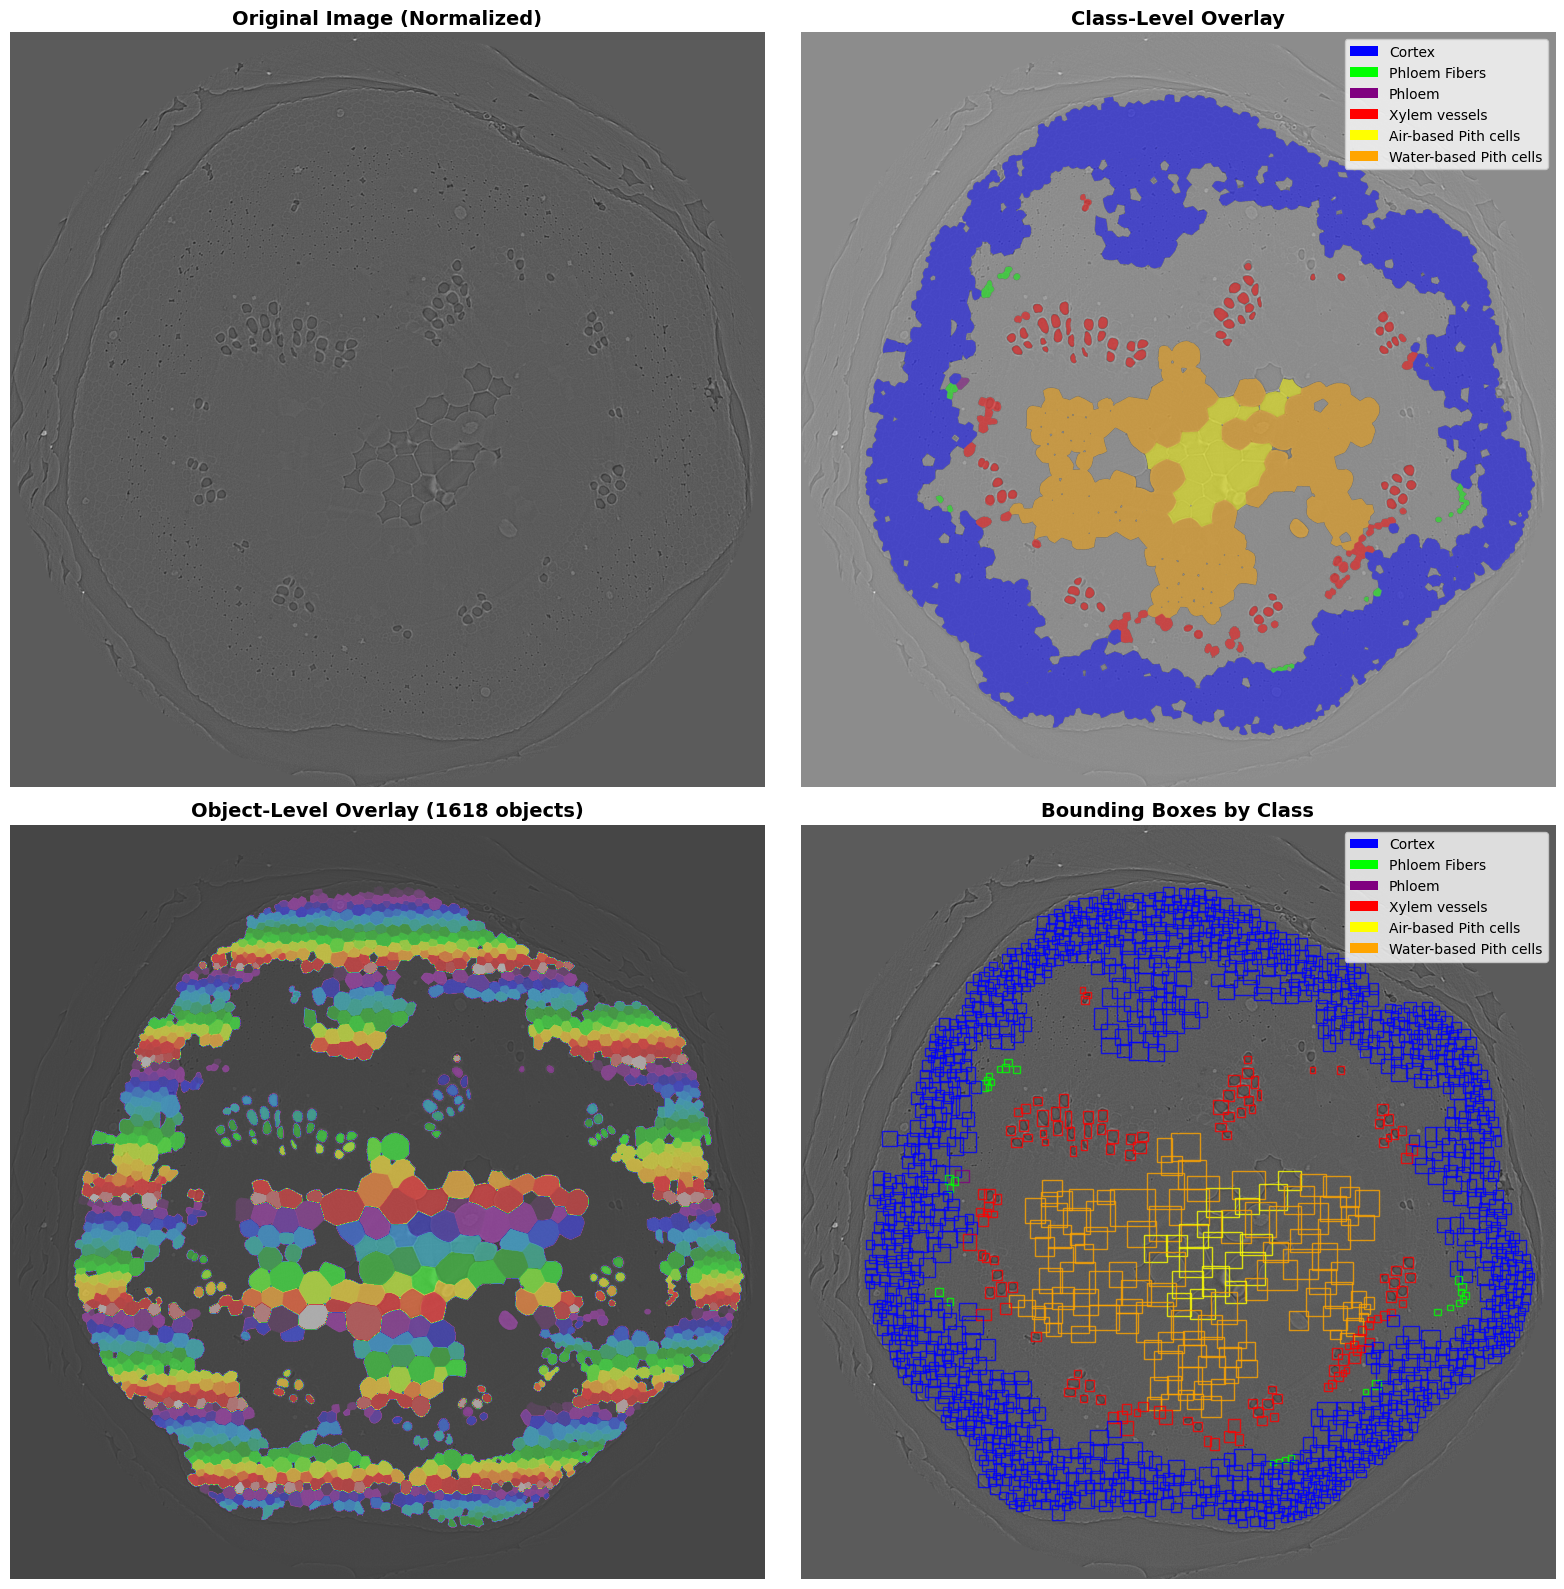

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from pathlib import Path
import random

def normalize_image(img_array):
    """Normalize image to 0-1 range for display."""
    img_min = img_array.min()
    img_max = img_array.max()
    if img_max > img_min:
        return (img_array - img_min) / (img_max - img_min)
    return img_array

def load_coco_data(json_path):
    """Load COCO annotation file."""
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

def create_segmentation_mask(segmentation, img_shape, value):
    """Create a mask from segmentation polygon."""
    from PIL import Image, ImageDraw
    mask = Image.new('L', (img_shape[1], img_shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    
    # Convert flat list to list of tuples
    coords = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
    draw.polygon(coords, fill=value)
    
    return np.array(mask)

def find_random_image_with_coco():
    """
    Randomly select an image from ./data/images and find corresponding COCO JSON.
    
    Returns:
        tuple: (image_path, json_path) or (None, None) if no valid files
    """
    images_dir = Path("./data/images")
    coco_dir = Path("./data/coco")
    
    # Get all image files
    image_files = list(images_dir.glob("*.tiff")) + list(images_dir.glob("*.tif"))
    
    if not image_files:
        print("No image files found in ./data/images")
        return None, None
    
    # Shuffle and try to find valid file with COCO annotation
    random.shuffle(image_files)
    
    for image_path in image_files:
        base_name = image_path.stem
        
        # Look for corresponding COCO JSON
        json_path = coco_dir / f"{base_name}.json"
        
        if json_path.exists():
            print(f"\nRandomly selected: {image_path.name}")
            print(f"COCO annotation file: {json_path.name}")
            return image_path, json_path
    
    print("No image files found with corresponding COCO JSON files")
    return None, None

def visualize_coco_annotations(tiff_path, json_path, output_dir):
    """Visualize COCO annotations with class-level, object-level overlays and bboxes."""
    
    base_name = tiff_path.stem
    
    # Load image
    img = Image.open(tiff_path)
    img_array = np.array(img)
    img_normalized = normalize_image(img_array)
    
    # Load COCO data
    coco_data = load_coco_data(json_path)
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Print statistics
    print(f"\nTotal number of objects: {len(annotations)}")
    print(f"\nObjects per class:")
    class_counts = {}
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] = class_counts.get(cat_id, 0) + 1
    
    for cat_id, count in sorted(class_counts.items()):
        print(f"  {categories[cat_id]}: {count}")
    
    # Create masks
    class_mask = np.zeros(img_array.shape, dtype=np.uint8)
    object_mask = np.zeros(img_array.shape, dtype=np.uint8)
    
    # Fill masks
    for ann in annotations:
        segmentation = ann['segmentation'][0]
        category_id = ann['category_id']
        object_id = ann['id']
        
        # Class-level mask
        class_seg_mask = create_segmentation_mask(segmentation, img_array.shape, category_id)
        class_mask = np.maximum(class_mask, class_seg_mask)
        
        # Object-level mask (use modulo to cycle colors for many objects)
        obj_value = (object_id % 255) + 1
        obj_seg_mask = create_segmentation_mask(segmentation, img_array.shape, obj_value)
        object_mask = np.maximum(object_mask, obj_seg_mask)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # 1. Original normalized image
    axes[0, 0].imshow(img_normalized, cmap='gray')
    axes[0, 0].set_title('Original Image (Normalized)', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    # 2. Class-level overlay with custom colors
    # Define custom colors for each class (normalized to 0-1 with alpha)
    class_colors = {
        1: [0, 0, 1, 0.5],              # Blue - Cortex
        2: [0, 1, 0, 0.5],              # Green - Phloem Fibers
        3: [128/255, 0, 128/255, 0.5],  # Purple - Phloem
        4: [1, 0, 0, 0.5],              # Red - Xylem vessels
        5: [1, 1, 0, 0.5],              # Yellow - Air-based Pith cells
        6: [1, 165/255, 0, 0.5]         # Orange - Water-based Pith cells
    }
    
    axes[0, 1].imshow(img_normalized, cmap='gray', alpha=0.7)
    
    # Create colored overlay
    class_overlay_rgb = np.zeros((*img_array.shape, 4))
    for cat_id, color in class_colors.items():
        mask_region = class_mask == cat_id
        for c in range(4):
            class_overlay_rgb[:, :, c][mask_region] = color[c]
    
    axes[0, 1].imshow(class_overlay_rgb)
    axes[0, 1].set_title('Class-Level Overlay', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Add class legend with custom colors
    legend_elements = [
        mpatches.Patch(facecolor=[class_colors[i][0], class_colors[i][1], class_colors[i][2]], 
                      label=categories[i]) 
        for i in sorted(categories.keys())
    ]
    axes[0, 1].legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    # 3. Object-level overlay
    axes[1, 0].imshow(img_normalized, cmap='gray', alpha=0.7)
    object_overlay = axes[1, 0].imshow(object_mask, cmap='nipy_spectral', alpha=0.5)
    axes[1, 0].set_title(f'Object-Level Overlay ({len(annotations)} objects)', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')
    
    # 4. Bounding boxes with custom colors
    axes[1, 1].imshow(img_normalized, cmap='gray')
    
    # Define custom colors for bboxes (RGB normalized to 0-1, without alpha)
    bbox_colors = {
        1: [0, 0, 1],              # Blue - Cortex
        2: [0, 1, 0],              # Green - Phloem Fibers
        3: [128/255, 0, 128/255],  # Purple - Phloem
        4: [1, 0, 0],              # Red - Xylem vessels
        5: [1, 1, 0],              # Yellow - Air-based Pith cells
        6: [1, 165/255, 0]         # Orange - Water-based Pith cells
    }
    
    # Draw bboxes from JSON
    for ann in annotations:
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']
        color = bbox_colors[category_id]
        
        rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                         linewidth=1, edgecolor=color, facecolor='none', alpha=0.8)
        axes[1, 1].add_patch(rect)
    
    axes[1, 1].set_title('Bounding Boxes by Class', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Add bbox legend with custom colors
    legend_elements_bbox = [
        mpatches.Patch(facecolor=bbox_colors[i], label=categories[i]) 
        for i in sorted(categories.keys())
    ]
    axes[1, 1].legend(handles=legend_elements_bbox, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    # Save to output directory
    output_path = output_dir / f"{base_name}_coco_visualization.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\nVisualization saved to: {output_path}")
    plt.show()

# Usage
if __name__ == "__main__":
    # Create verification output directory
    verification_dir = Path("./data/verification")
    verification_dir.mkdir(parents=True, exist_ok=True)
    
    # Randomly select an image and find corresponding COCO JSON
    image_path, json_path = find_random_image_with_coco()
    
    if image_path is None:
        print("\nError: Could not find a valid image with COCO JSON file.")
        print("Please ensure:")
        print("  1. Images exist in ./data/images")
        print("  2. COCO JSON files exist in ./data/coco")
    else:
        visualize_coco_annotations(image_path, json_path, verification_dir)